In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
batch_size = 64

In [4]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(root="data/synthetic_imagenette/", transform=transform)
test_dataset = ImageFolder(root="data/real/imagenette/val", transform=transform)




In [5]:
sample_sizes = [10,20,35,50,75,100, ]#300, 500, 800, 1000]


In [6]:
from torch.utils.data import random_split

def create_data_loaders(train_dataset, test_dataset, batch_size, val_split=0.2):
    # Calculate the number of samples to use for validation
    n_total = len(train_dataset)
    n_val = int(val_split * n_total)
    n_train = n_total - n_val

    # Split the train dataset into train and validation
    train_data, val_data = random_split(train_dataset, [n_train, n_val])

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [7]:
train_loader,val_loader,test_loader = create_data_loaders(train_dataset,test_dataset,batch_size)

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / len(dataloader), 100. * correct / total



In [9]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(dataloader), 100. * correct / total


In [10]:

def train_and_evaluate(sample_sizes):
    results = {}
    for sample_size in sample_sizes:
        # Subset the datasets
        train_subset = Subset(train_dataset, list(range(sample_size)))
        
        # Create data loaders with validation split
        train_loader, val_loader, test_loader = create_data_loaders(train_subset, test_dataset, batch_size)

        # Model setup
        model = resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 3)
        model = model.to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        # Training and evaluation
        num_epochs = 10
        train_losses, val_losses, test_losses = [], [], []
        train_accuracies, val_accuracies, test_accuracies = [], [], []

        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            # Validation
            model.eval()
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            
            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


        # Test
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print(f"Final Test Results:")
        print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        results[sample_size] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "test_accuracies": test_accuracies
        }
    return results


In [11]:
results = train_and_evaluate(sample_sizes)


c:\Users\kashp\miniconda3\envs\cva3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kashp\miniconda3\envs\cva3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:
  Train Loss: 1.2223, Train Acc: 0.00%
  Val Loss: 1.2946, Val Acc: 0.00%
Epoch 2/10:
  Train Loss: 1.0568, Train Acc: 62.50%
  Val Loss: 1.1838, Val Acc: 0.00%
Epoch 3/10:
  Train Loss: 0.9217, Train Acc: 75.00%
  Val Loss: 1.0475, Val Acc: 50.00%
Epoch 4/10:
  Train Loss: 0.7638, Train Acc: 100.00%
  Val Loss: 0.8243, Val Acc: 100.00%
Epoch 5/10:
  Train Loss: 0.6561, Train Acc: 100.00%
  Val Loss: 0.7937, Val Acc: 100.00%
Epoch 6/10:
  Train Loss: 0.5593, Train Acc: 100.00%
  Val Loss: 0.4986, Val Acc: 100.00%
Epoch 7/10:
  Train Loss: 0.4668, Train Acc: 100.00%
  Val Loss: 0.4565, Val Acc: 100.00%
Epoch 8/10:
  Train Loss: 0.3722, Train Acc: 100.00%
  Val Loss: 0.3465, Val Acc: 100.00%
Epoch 9/10:
  Train Loss: 0.3083, Train Acc: 100.00%
  Val Loss: 0.3472, Val Acc: 100.00%
Epoch 10/10:
  Train Loss: 0.2609, Train Acc: 100.00%
  Val Loss: 0.2789, Val Acc: 100.00%
Final Test Results:
  Test Loss: 1.5427, Test Acc: 30.64%
Epoch 1/10:
  Train Loss: 0.8804, Train Acc: 93.75

In [12]:
for size, data in results.items():
    print(f"Sample size {size}:")
    print(f"  Final train accuracy: {data['train_accuracies'][-1]:.2f}%")
    print(f"  Final val accuracy: {data['val_accuracies'][-1]:.2f}%")

    print(f"  Final test accuracy: {data['test_accuracies'][-1]:.2f}%")


Sample size 10:
  Final train accuracy: 100.00%
  Final val accuracy: 100.00%
  Final test accuracy: 30.64%
Sample size 20:
  Final train accuracy: 100.00%
  Final val accuracy: 100.00%
  Final test accuracy: 30.64%
Sample size 35:
  Final train accuracy: 100.00%
  Final val accuracy: 100.00%
  Final test accuracy: 30.64%
Sample size 50:
  Final train accuracy: 100.00%
  Final val accuracy: 100.00%
  Final test accuracy: 30.64%
Sample size 75:
  Final train accuracy: 100.00%
  Final val accuracy: 100.00%
  Final test accuracy: 30.64%
Sample size 100:
  Final train accuracy: 100.00%
  Final val accuracy: 100.00%
  Final test accuracy: 30.64%


ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

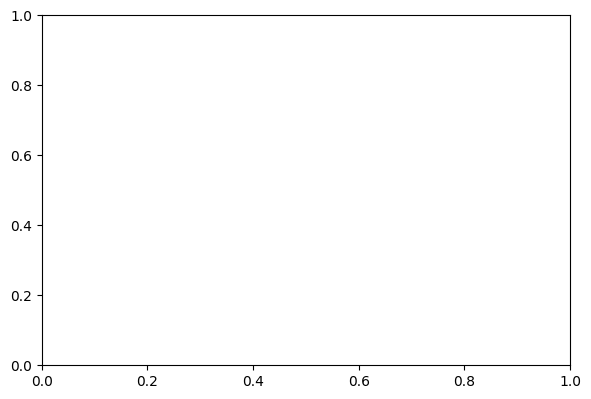

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for size, data in results.items():
    plt.plot(range(1, 6), data["train_losses"], label=f"Train {size}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(2, 2, 2)
for size, data in results.items():
    plt.plot(range(1, 6), data["test_losses"], label=f"Test {size}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss")
plt.legend()

plt.subplot(2, 2, 3)
for size, data in results.items():
    plt.plot(range(1, 6), data["train_accuracies"], label=f"Train {size}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()

plt.subplot(2, 2, 4)
for size, data in results.items():
    plt.plot(range(1, 6), data["test_accuracies"], label=f"Test {size}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
